https://publications.lib.chalmers.se/records/fulltext/250503/250503.pdf

In [ ]:
!pip3 install obci_readmanager
!pip3 install varname
!pip3 install PyWavelets
!pip3 install pyts
!pip3 install scipy
!pip3 install sklearn

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 6.2MB 5.0MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194576 sha256=37d4e65e19688372038227a408351256d0d36f5f90f2555e1193a606f0a00817
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne
     |████████████████████████████████| 2.5MB 4.0MB/s 


In [ ]:
#Importy
from varname import nameof
import pandas as pd
import pywt
from obci_readmanager.signal_processing.read_manager import ReadManager
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtpl
import scipy.io.wavfile
import scipy.signal as ss
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów
from  scipy.signal import butter
import matplotlib.collections as collections

from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
import more_itertools as mit

In [ ]:
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linestyle": '--', "grid.linewidth": 0.5 })
#plt.subplots_adjust(top = 1, bottom = 0.3, wspace=1, hspace=2)

2021-06-01 11:42:41,434 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['hor', 'ver', 'TSS']
['middle', 'prawo', 'gora', 'lewo', 'dol']


Text(0, 0.5, 'Voltage [uV]')

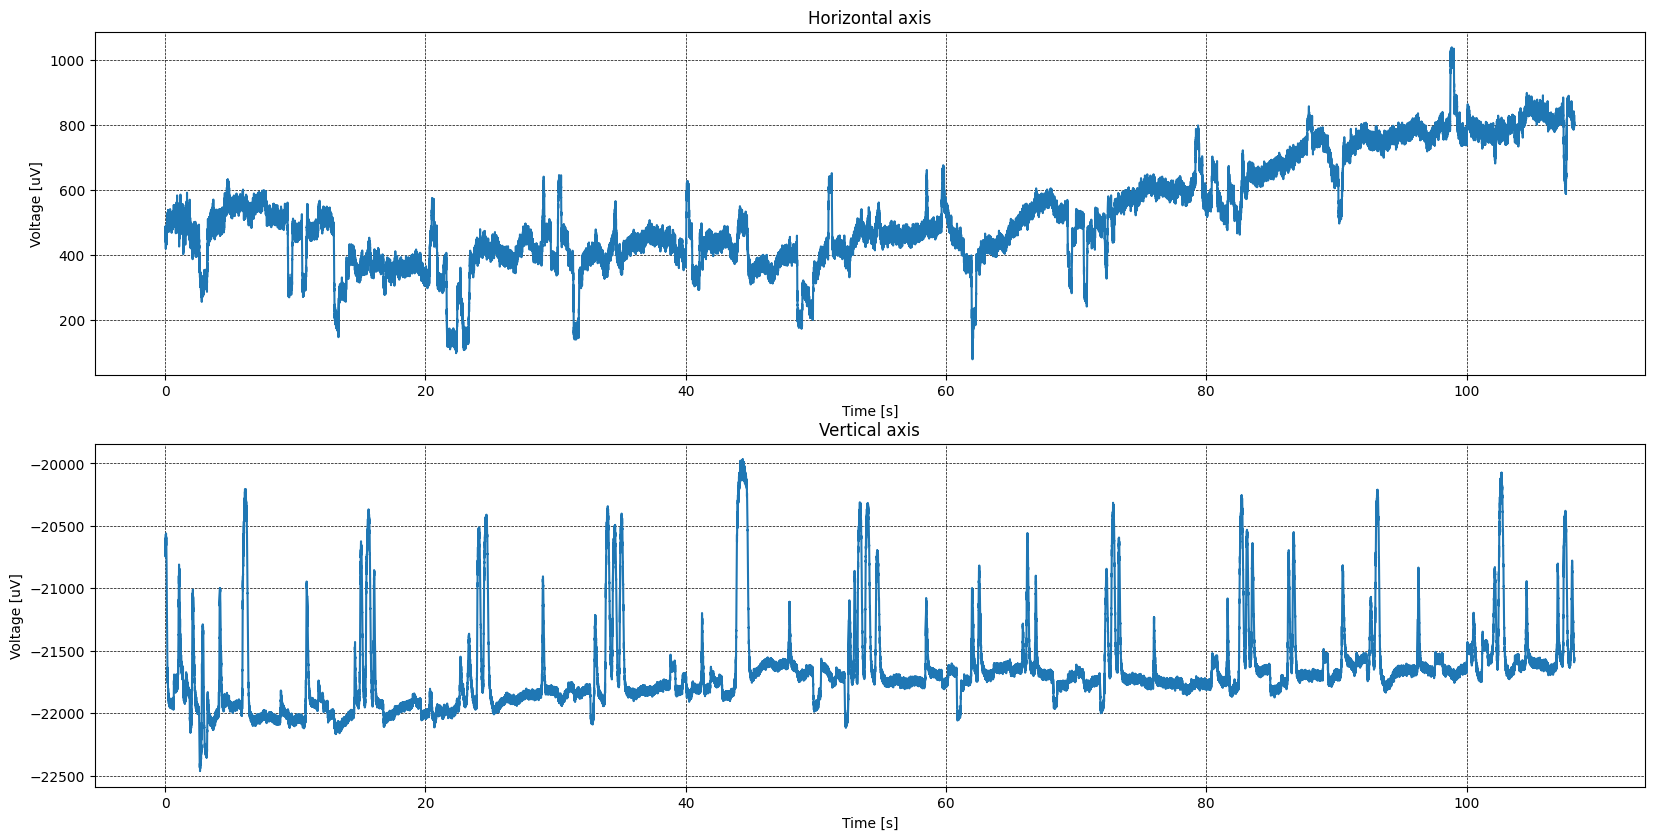

In [ ]:
eog1 = ReadManager("eog_kwadraty_lukasz2.xml", "eog_kwadraty_lukasz2.raw", "eog_kwadraty_lukasz2.tag")

channels_names_1 = eog1.get_param("channels_names")

print(channels_names_1)

# Pobierz cały, wybrany kanał
HOR = eog1.get_channel_samples("hor") * 0.0715
VER = eog1.get_channel_samples("ver") * 0.0715

#Parametry podstawowe
Fs = 2048
T = len(HOR)/Fs 
dt = 1/Fs
t = np.arange(0,T,dt)
f = np.arange(0.01,Fs/2,0.01)

# Pobierz wszystkie znaczniki
tags = eog1.get_tags()
tagnames = []
for tag in tags:
  if tag['name'] not in tagnames:
    tagnames.append(tag['name'])
print(tagnames)

#Plotuję surowe sygnały
plt.subplot(2,1,1)
plt.plot(t,HOR)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,VER)
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

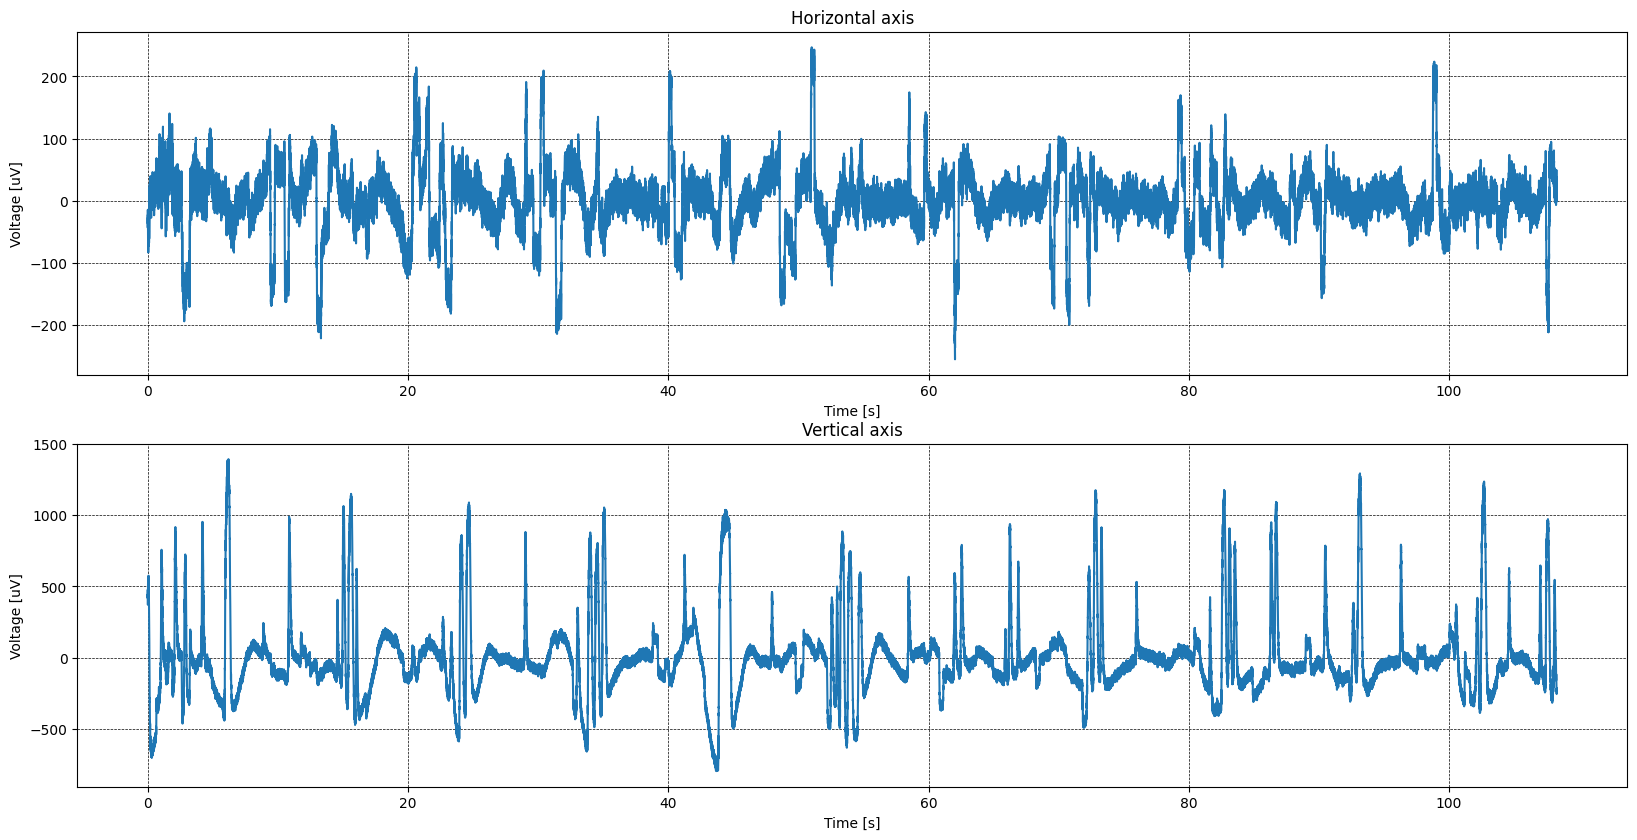

In [ ]:
#print(pywt.wavelist())

sf = []
for sig in [HOR, VER]:
  coeffs = pywt.wavedec(sig, 'rbio6.8', level=12)
  for i in range(1,len(coeffs)): #powinno być 1 w range pierwsze
    coeffs[i] = np.zeros(len(coeffs[i]))
  s = pywt.waverec(coeffs, wavelet = 'rbio6.8')
  sf.append(sig - s)

plt.subplot(2,1,1)
plt.plot(t,sf[0])
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,sf[1])
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]') 

In [ ]:
#sigs = [HOR, VER]
sigs = [sf[0], sf[1]]

def filtry(sigs:list=[]) -> list:
  filtered_channels = []
  for channel in sigs:
    [b1,a1]=butter(1,0.5,fs=Fs,btype='highpass')
    sf1 = filtfilt(b1, a1, channel)
    [b2,a2] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
    sf2 = filtfilt(b2, a2, sf1) #Notch
    [b3,a3]=butter(1,15,fs=Fs,btype='lowpass')
    sf3 = filtfilt(b3, a3, sf2)
    #sf3 = sf3**2
    filtered_channels.append(sf3)
  return filtered_channels

def moving_average(syg, Fs, winlength):
  pds = pd.Series(syg)  
  windows = pds.rolling(int(winlength))  
  moving_averages = windows.mean()
  result = moving_averages.tolist()
  #result = result[int(winlength) - 1:]
  return result

H, V = filtry(sigs)

#H = moving_average(H, Fs, winlength = 0.1*Fs)
#V = moving_average(V, Fs, winlength = 0.1*Fs)

#H = (filtry(sigs)[0]+sf[0])*0.5
#V = (filtry(sigs)[1]+sf[1])*0.5

Text(0, 0.5, 'Voltage [uV]')

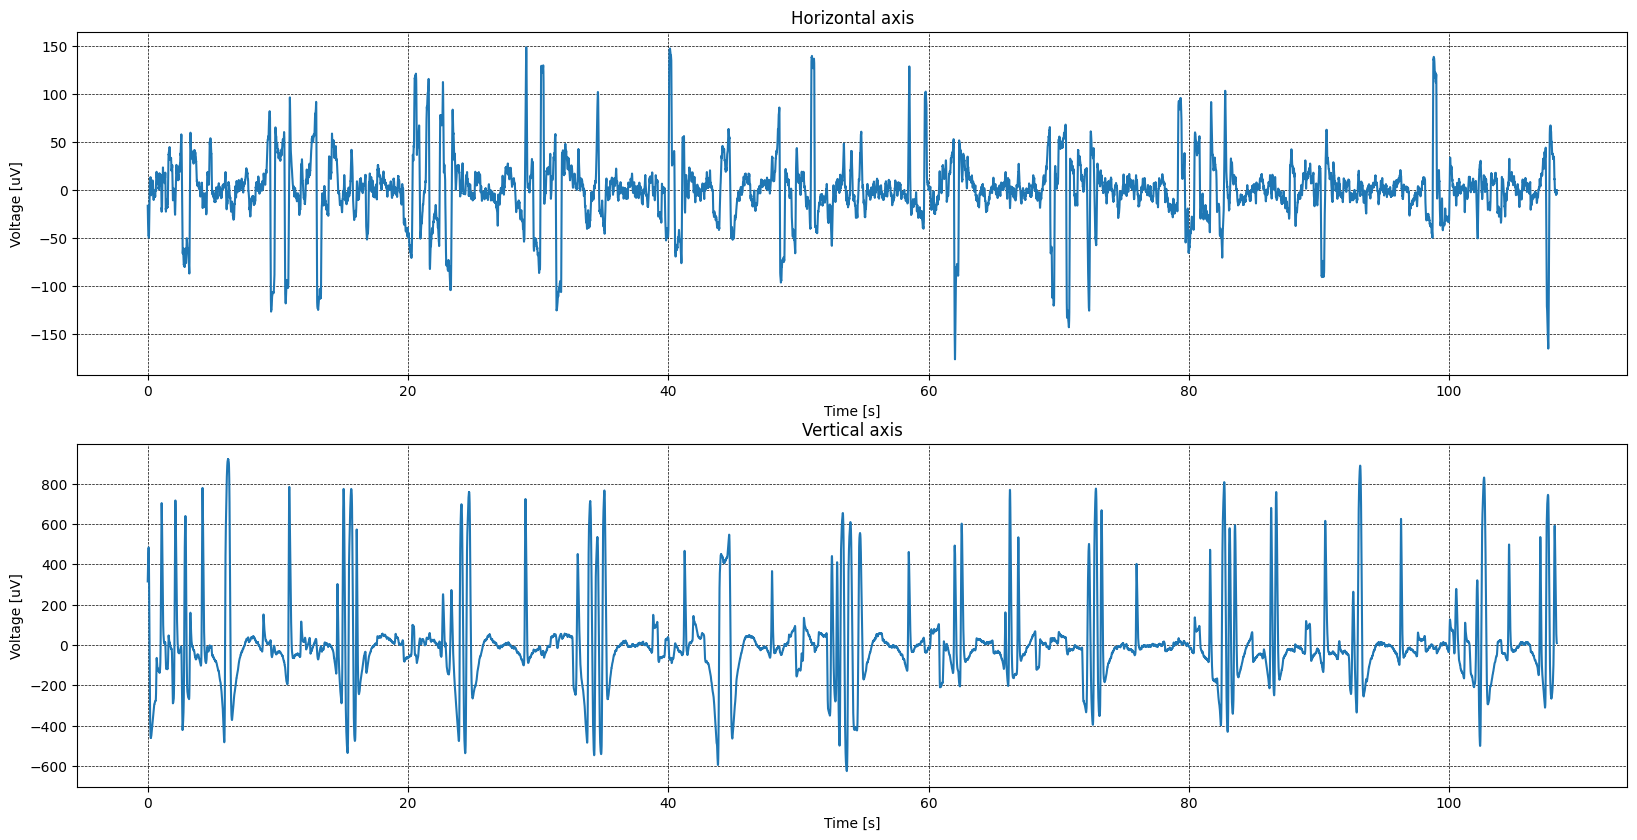

In [ ]:
plt.subplot(2,1,1)
plt.plot(t,H)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,V)
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

In [ ]:
#Tagi
MTags = np.zeros(len(t))
LTags = np.zeros(len(t))
RTags = np.zeros(len(t))
UTags = np.zeros(len(t))
DTags = np.zeros(len(t))

mtp = []
ltp = []
rtp = []
utp = []
dtp = []

for item in tags:
  if item['name'] == 'middle':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    MTags[idx0:idx1] = 1
    mtp.append((idx0,idx1))
  if item['name'] == 'lewo':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    LTags[idx0:idx1] = 1
    ltp.append((idx0,idx1))
  if item['name'] == 'prawo':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    RTags[idx0:idx1] = 1
    rtp.append((idx0,idx1))
  if item['name'] == 'gora':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    UTags[idx0:idx1] = 1
    utp.append((idx0,idx1))
  if item['name'] == 'dol':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    DTags[idx0:idx1] = 1
    dtp.append((idx0,idx1))

No handles with labels found to put in legend.


Text(0, 0.5, 'Voltage [uV]')

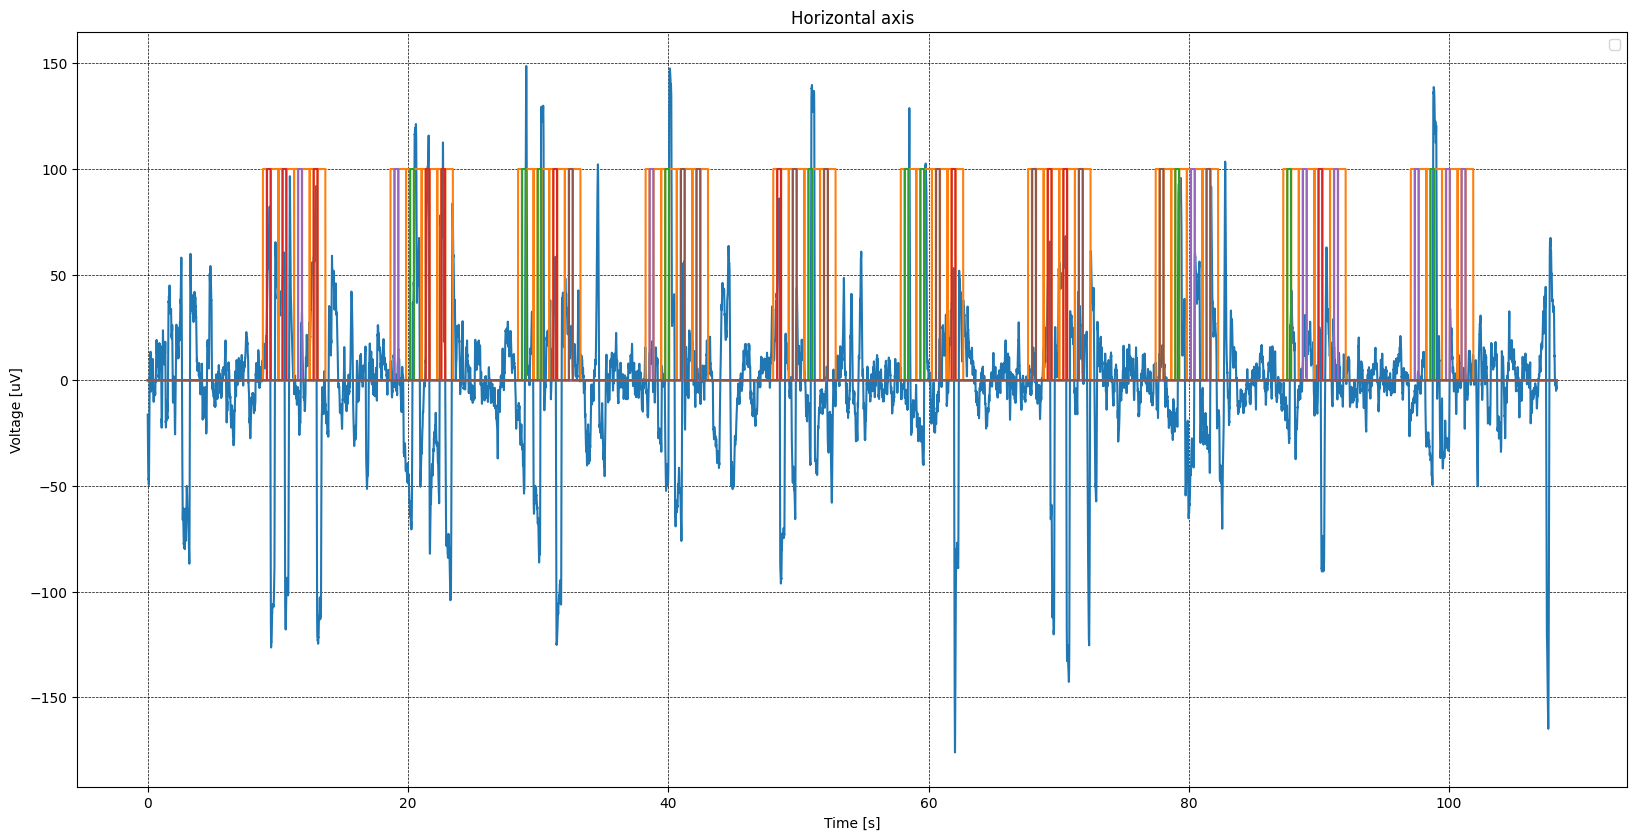

In [ ]:
plt.plot(t,H)
plt.plot(t,MTags*100)
plt.plot(t,LTags*100)
plt.plot(t,RTags*100)
plt.plot(t,UTags*100)
plt.plot(t,DTags*100)
plt.legend()
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

In [ ]:
def FindSequence(syg, seqLen, val, mode = 'ReturnPeaks', dir = 'greater'):
  syg = list(syg)
  if dir == 'greater':
    indexes = [syg.index(i) for i in syg if i >= val]
  elif dir == 'lower':
    indexes = [syg.index(i) for i in syg if i <= val]
  temp = [list(group) for group in mit.consecutive_groups(indexes)]
  result =  [group for group in temp if len(group) >= seqLen]
  if mode == 'ReturnPeaks':
    return result
  elif mode == 'ReturnPeaksLengths':
    return result, [len(group) for group in result]
  elif mode == 'ReturnPeakLengthsAndSigValues':
    values = []
    for r in result:
      values.append([syg[i] for i in r])
    return values, [len(group) for group in result], result
  elif mode == 'ReturnBool':
    if len(result) != 0:
      return True 
    else:
      return False


In [ ]:
fsigs = [H, V]
#tg = [MTags,LTags,RTags,UTags,DTags]
tg = [ltp, rtp, utp, dtp]

movements = {}
transforms = {}

saccade_candidates = {
    'hor': H*-1,
    'ver': V*-1,
}

saccade_sets = {
    'hor': [],
    'ver': [],
}

seqChars = {
    '00': (290, 90, 'greater'),
    '01': (290, -80, 'lower'),
    '02': (400, 30, 'greater'),
    '03': (290, 90, 'greater'),
    '10': (430, 90, 'greater'),
    '11': (450, 90, 'greater'),
    '12': (400, 40, 'greater'),
    '13': (290, -180, 'lower'),
}

hor_pos_train = [[],[],[]]
hor_neg_train = [[],[],[]]
ver_pos_train = [[],[],[]]
ver_neg_train = [[],[],[]]


mn = mtp[0][1]-mtp[0][0]

for s in range(len(fsigs)):
  for tt in range(len(tg)):
    key = str(s)+str(tt)
    movements[key] = []
    transforms[key] = []
    for pair in tg[tt]:
      #Wycinanie sakad do rysunków
      diff = int(1.2*Fs) - pair[1]+pair[0]-mn
      tagged =  fsigs[s][pair[0]-mn:pair[1]+diff]
      movements[key].append(tagged)#-np.mean(fsigs[s][pair[0]-mn-Fs:pair[1]+mn*2+Fs]))

      #Przygotowanie training datasetu, Boże przebacz tą składnię
      p, l, inds = FindSequence(tagged, seqChars[key][0], seqChars[key][1], mode = 'ReturnPeakLengthsAndSigValues', dir = seqChars[key][2])
      if key[0] == '0' and seqChars[key][1] > 0:
        if p != []:
          hor_pos_train[0].append(np.mean(p[0]))
          hor_pos_train[1].append(l[0])
          hor_pos_train[2].append(1)
        else:
          p, l, inds = FindSequence(tagged, seqChars[key][0]//2, seqChars[key][1], mode = 'ReturnPeakLengthsAndSigValues', dir = seqChars[key][2])
          if p != []:
            hor_pos_train[0].append(np.mean(p[0]))
            hor_pos_train[1].append(l[0])
            hor_pos_train[2].append(0)

      elif key[0] == '0' and seqChars[key][1] < 0:
        if p != []:
          hor_neg_train[0].append(np.mean(p[0]))
          hor_neg_train[1].append(l[0])
          hor_neg_train[2].append(1)
        else:
          p, l, inds = FindSequence(tagged, seqChars[key][0]//2, seqChars[key][1], mode = 'ReturnPeakLengthsAndSigValues', dir = seqChars[key][2])
          if p != []:
            hor_neg_train[0].append(np.mean(p[0]))
            hor_neg_train[1].append(l[0])
            hor_neg_train[2].append(0)

      elif key[0] == '1' and seqChars[key][1] > 0:
        if p != []:
          ver_pos_train[0].append(np.mean(p[0]))
          ver_pos_train[1].append(l[0])      
          ver_pos_train[2].append(1)
        else:
          p, l, inds = FindSequence(tagged, seqChars[key][0]//2, seqChars[key][1], mode = 'ReturnPeakLengthsAndSigValues', dir = seqChars[key][2])
          if p != []:
            ver_pos_train[0].append(np.mean(p[0]))
            ver_pos_train[1].append(l[0])
            ver_pos_train[2].append(0)

      elif key[0] == '1' and seqChars[key][1] < 0:
        if p != []:
          ver_neg_train[0].append(np.mean(p[0]))
          ver_neg_train[1].append(l[0])        
          ver_neg_train[2].append(1)
        else:
          p, l, inds = FindSequence(tagged, seqChars[key][0]//2, seqChars[key][1], mode = 'ReturnPeakLengthsAndSigValues', dir = seqChars[key][2])
          if p != []:
            ver_neg_train[0].append(np.mean(p[0]))
            ver_neg_train[1].append(l[0])
            ver_neg_train[2].append(0)
      
      #Przygotowanie periodogramów
      okno = np.blackman(len(tagged)/20)
      okno /= np.linalg.norm(okno)
      (F,P)= ss.welch(tagged, fs=Fs, window=okno, nperseg=len(okno), noverlap=len(okno)//2, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
      transforms[key].append((F,P))

      #Przygotowanie zestawów ładnych sakad, to chyba nie będzie już używane
      if key[0] == '0' and FindSequence(tagged, seqChars[key][0], seqChars[key][1], mode = 'ReturnBool', dir = seqChars[key][2]) == True:
        saccade_candidates['hor'][pair[0]-mn:pair[1]+diff] = fsigs[s][pair[0]-mn:pair[1]+diff]
        saccade_sets['hor'].append(tagged)
      elif key[0] == '1' and FindSequence(tagged, seqChars[key][0], seqChars[key][1], mode = 'ReturnBool', dir = seqChars[key][2]) == True:
        saccade_candidates['ver'][pair[0]-mn:pair[1]+diff] = fsigs[s][pair[0]-mn:pair[1]+diff]
        saccade_sets['ver'].append(tagged)

    sn, tn, key = None, None, None

print(movements.keys())


dict_keys(['00', '01', '02', '03', '10', '11', '12', '13'])


In [ ]:
movement_names = {}
for key in movements.keys():
  if key[0] == '0':
    y = 'Horizontal'
  else:
    y = 'Vertical'
  if key[1] == '0':
    x = 'Leftwards'
  elif key[1] == '1':
    x = 'Rightwards'
  elif key[1] == '2':
    x = 'Upwards'
  elif key[1] == '3':
    x = 'Downwards'
  name = y + '-' + x
  movement_names[key] = name

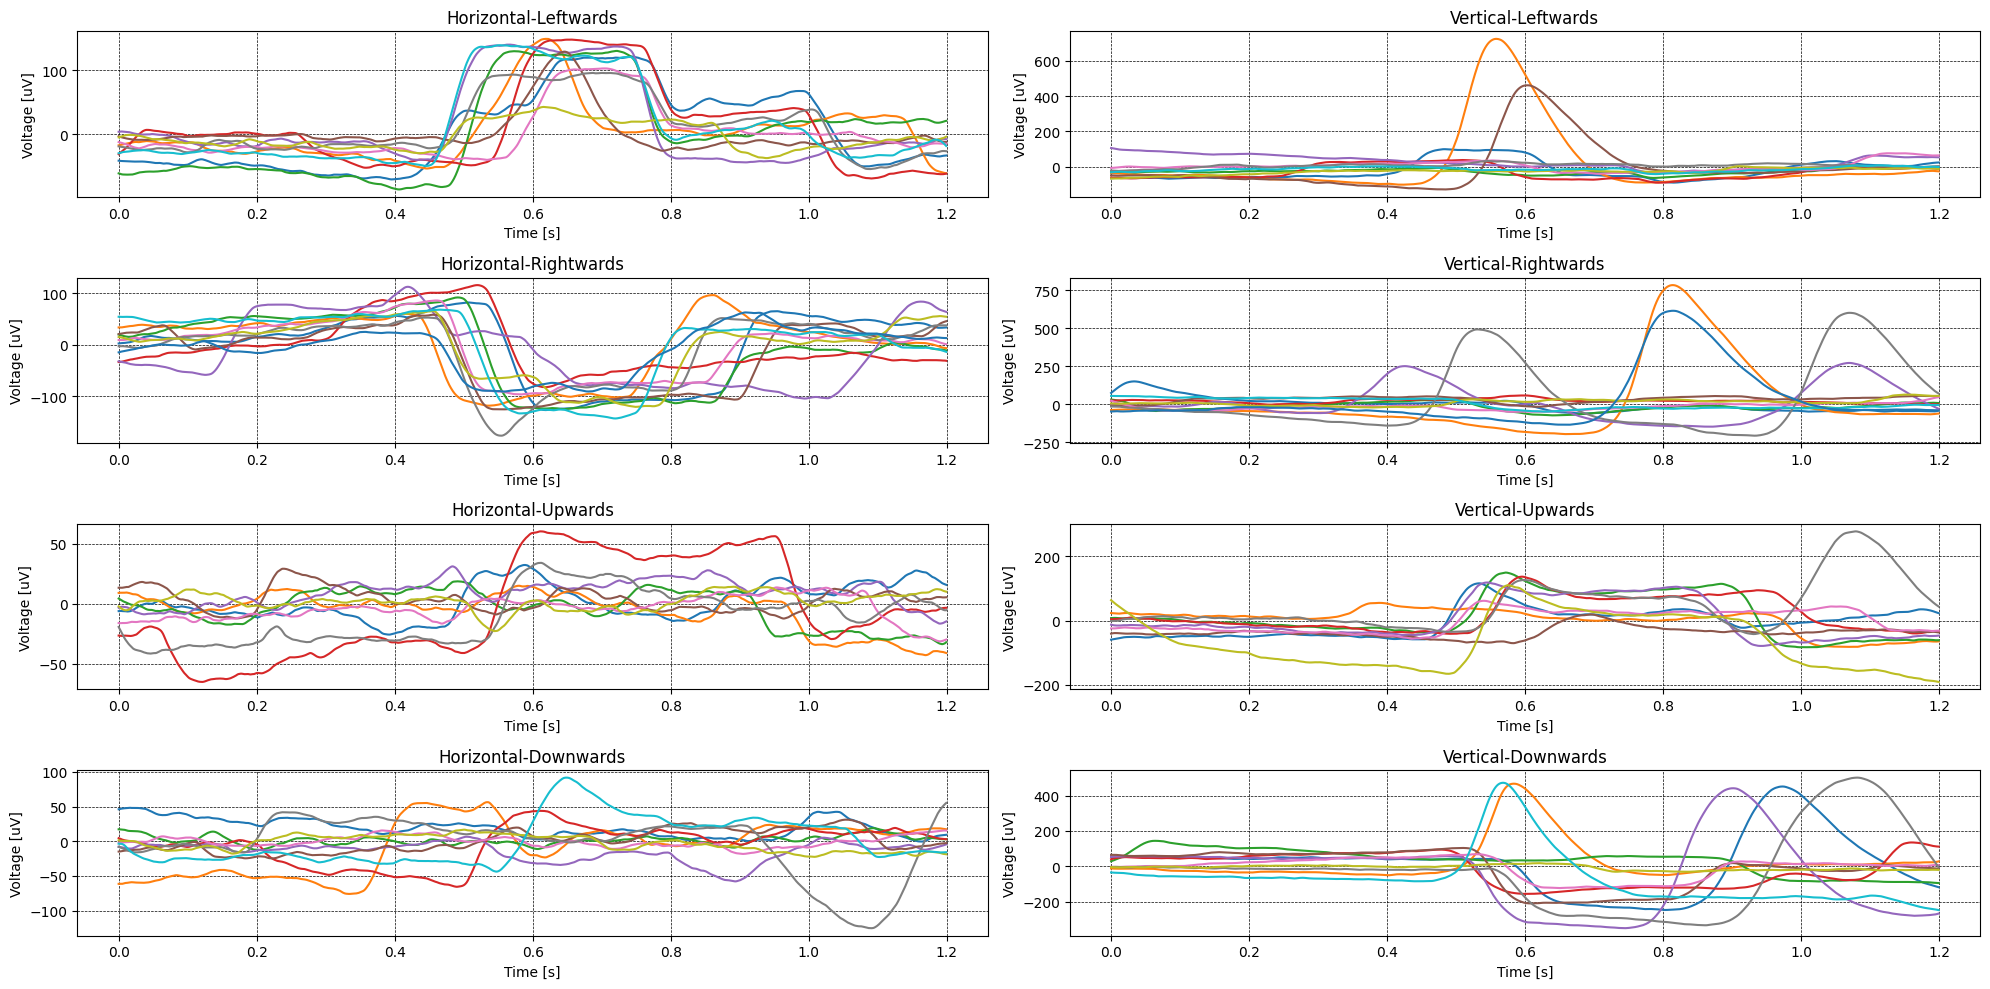

In [ ]:
plt.figure(tight_layout = True)
for key in movements.keys():
  if int(key[0]) == 0:
    plt.subplot(4,2,int(key[1])*2+1)
  else:
    plt.subplot(4,2,(int(key[1])+int(key[0]))*2)
  for item in movements[key]:
    plt.plot(np.arange(0,len(item)/Fs,1/Fs),item)
    plt.title(movement_names[key])
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [uV]')
plt.show()

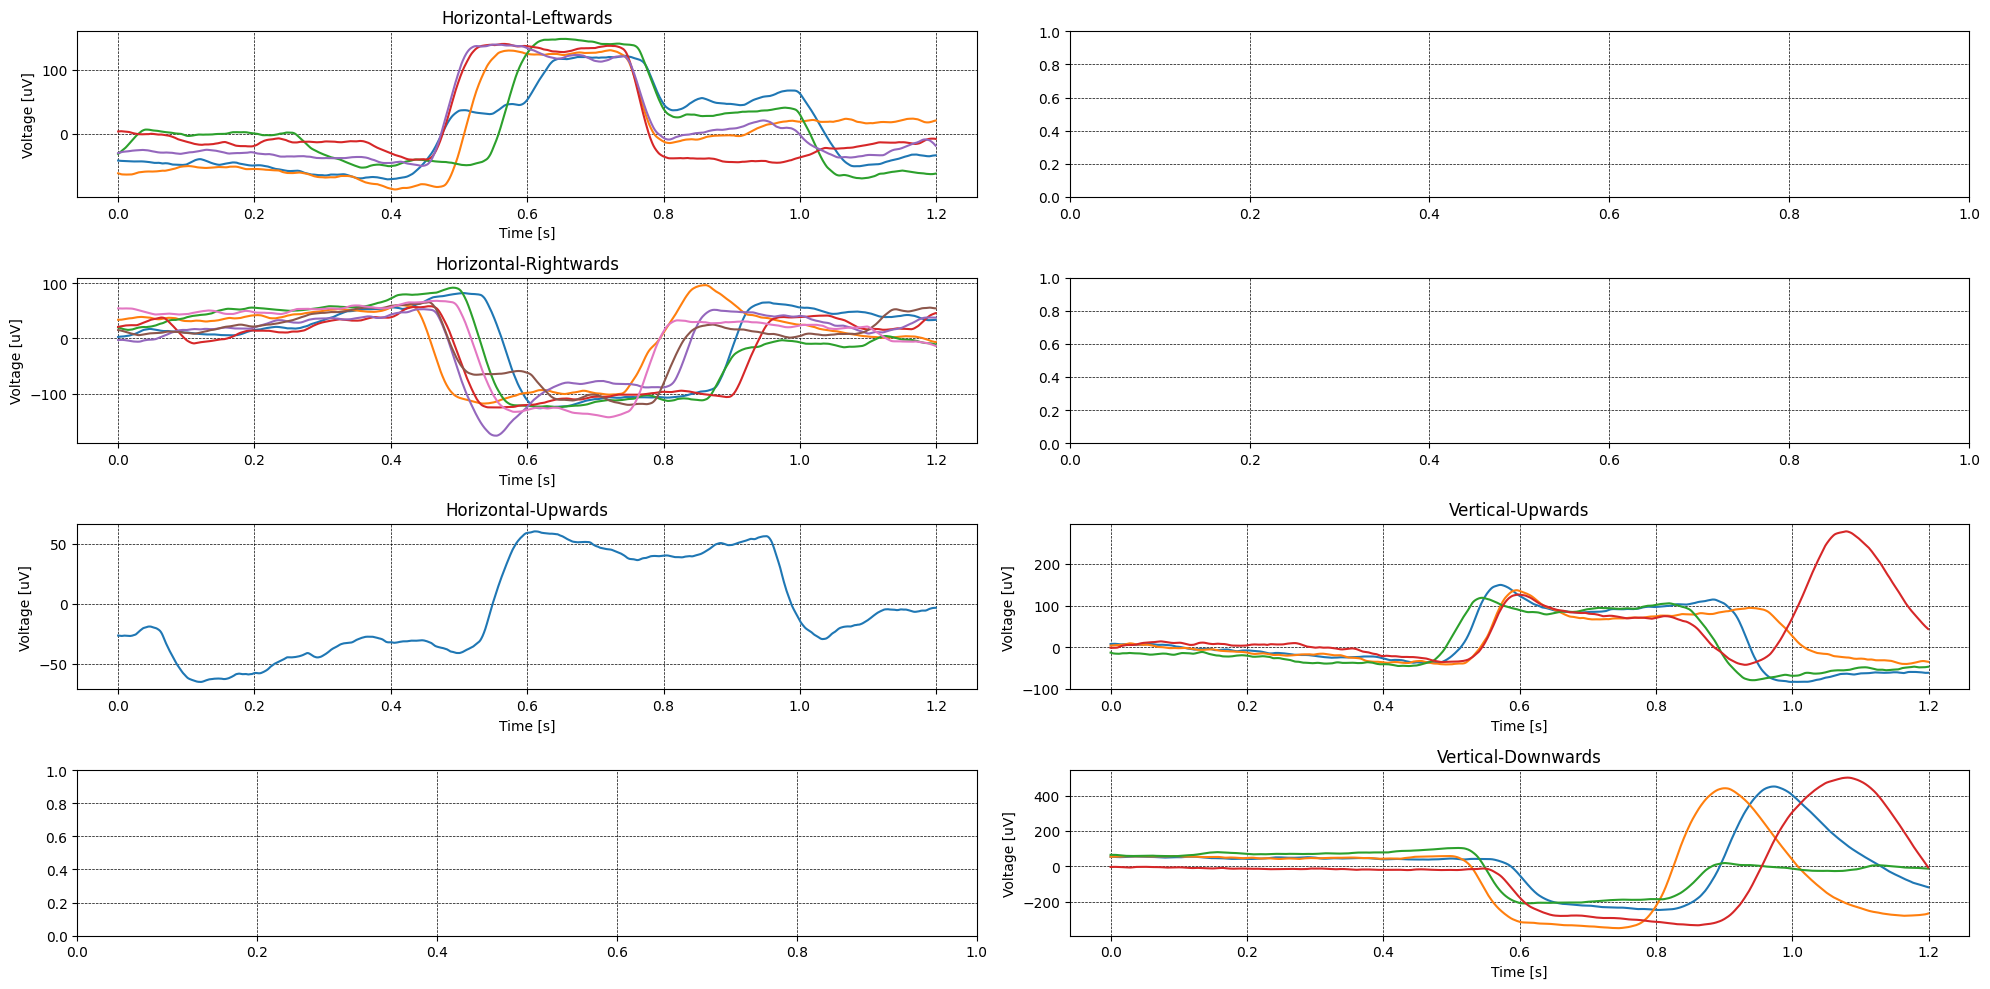

In [ ]:
plt.figure(tight_layout = True)
for key in movements.keys():
  if int(key[0]) == 0:
    plt.subplot(4,2,int(key[1])*2+1)
  else:
    plt.subplot(4,2,(int(key[1])+int(key[0]))*2)
  for item in movements[key]:
    if FindSequence(item, seqChars[key][0], seqChars[key][1], mode = 'ReturnBool', dir = seqChars[key][2]) == True:
      plt.plot(np.arange(0,len(item)/Fs,1/Fs),item)
      plt.title(movement_names[key])
      plt.xlabel('Time [s]')
      plt.ylabel('Voltage [uV]')
plt.show()

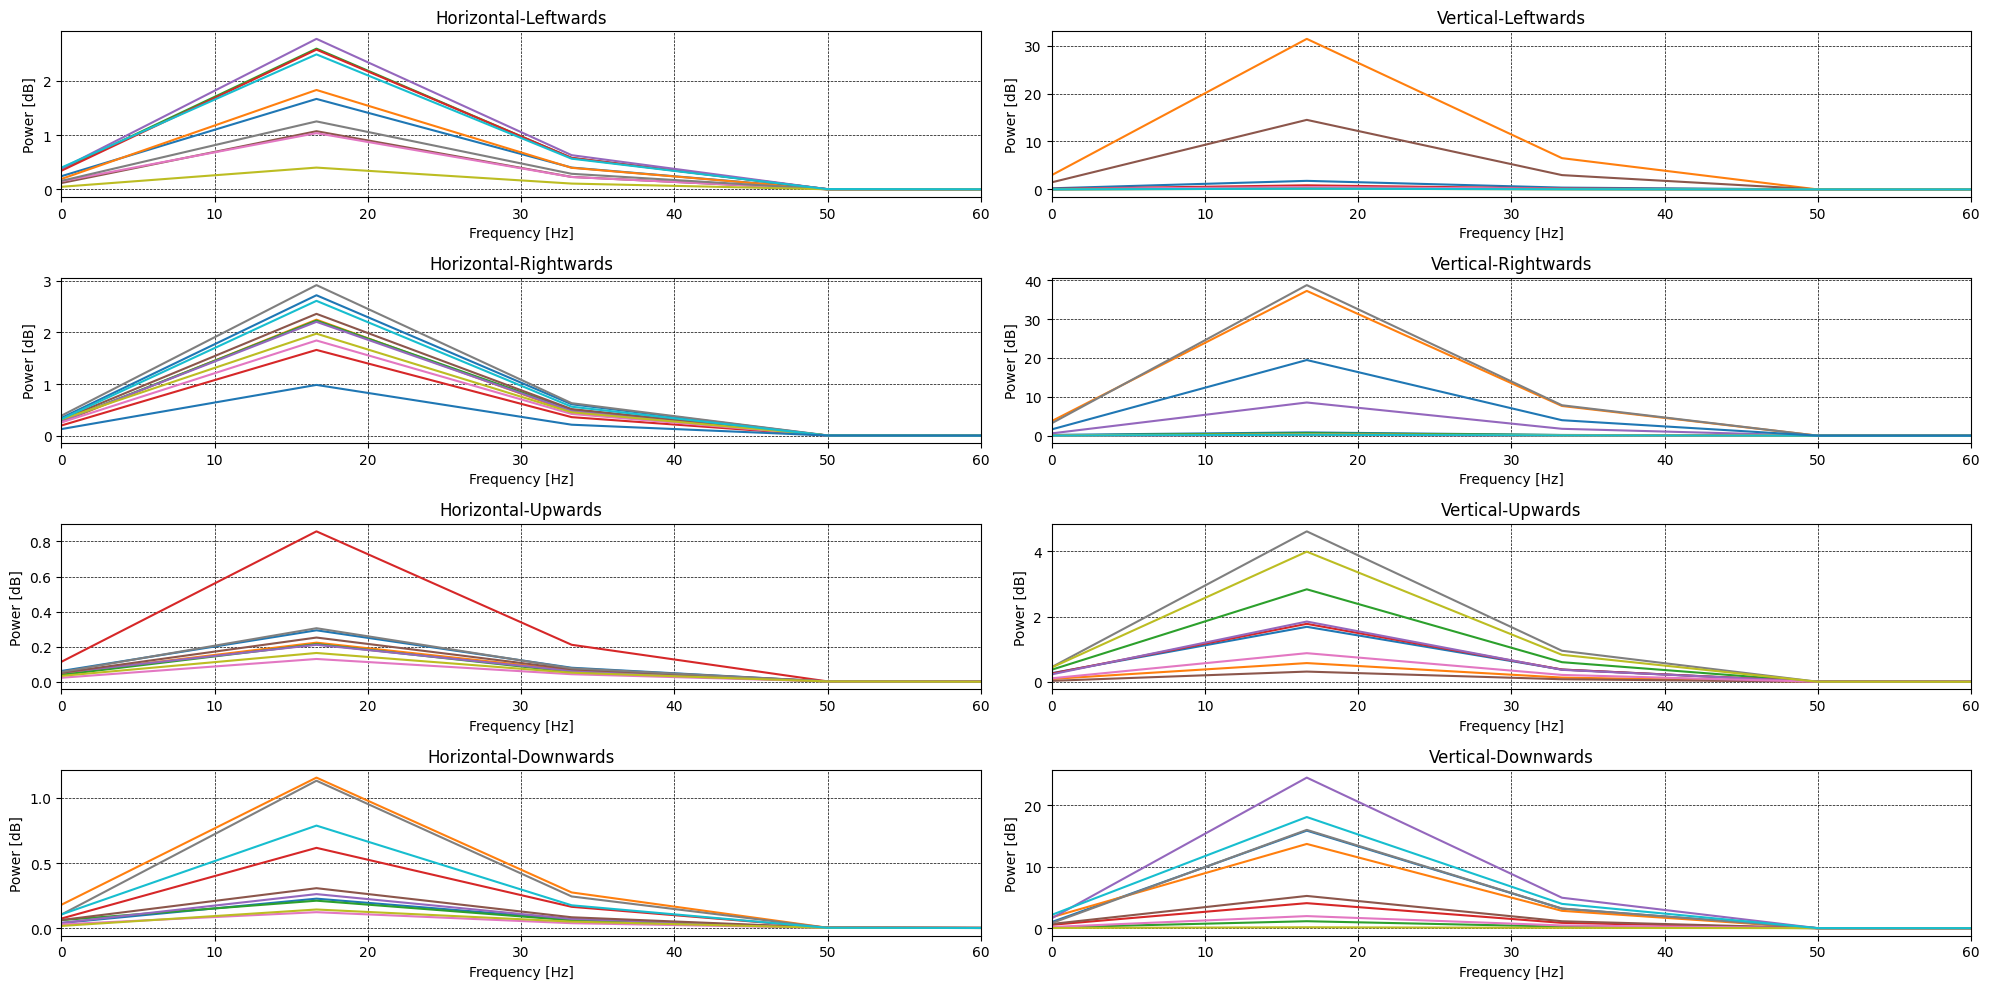

{'00': [], '01': [], '02': [], '03': [], '10': [1, 5], '11': [1, 4, 7, 10], '12': [7], '13': [0, 1, 4, 5, 7, 9]}


In [ ]:
possible_blinks = {}

plt.figure(tight_layout = True)
for key in transforms.keys():
  possible_blinks[key] = []
  if int(key[0]) == 0:
    plt.subplot(4,2,int(key[1])*2+1)
  else:
    plt.subplot(4,2,(int(key[1])+int(key[0]))*2)
  item_number = 0
  for item in transforms[key]:
    #print(movement_names[key], np.mean(item[1]))
    if np.mean(item[1]) > 0.09:
      possible_blinks[key].append(item_number)
    plt.plot(item[0], item[1])
    plt.title(movement_names[key])
    plt.xlabel('Frequency [Hz]')
    plt.xlim(0,60)
    plt.ylabel('Power [dB]')
    item_number += 1
plt.show()

print(possible_blinks)

Detekcja mrugnięć w vertical

"\nll = 20*Fs #8, 35\nhl = 80*Fs #26, 55\n\nplt.figure(tight_layout = True)\nplt.subplot(2,1,1)\nplt.plot(t[ll:hl], sf[0][ll:hl],linewidth=3.5)\n#plt.plot(t[ll:hl],H[ll:hl],linewidth=3.5)\nplt.plot(t[ll:hl],MTags[ll:hl]*100, label = 'middle', linewidth=2)\nplt.plot(t[ll:hl],LTags[ll:hl]*100, label = 'left', linewidth=2)\nplt.plot(t[ll:hl],RTags[ll:hl]*100, label = 'right', linewidth=2)\nplt.plot(t[ll:hl],UTags[ll:hl]*100, label = 'up', linewidth=2)\nplt.plot(t[ll:hl],DTags[ll:hl]*100, label = 'down', linewidth=2)\nplt.title('Horizontal axis')\nplt.xlabel('Time [s]')\nplt.ylabel('Voltage [uV]')\nplt.legend()\nplt.subplot(2,1,2)\nplt.plot(t[ll:hl], sf[1][ll:hl], linewidth=3.5)\nplt.plot(t[ll:hl],V[ll:hl],linewidth=3.5)\nplt.plot(t[ll:hl],MTags[ll:hl]*300, label = 'middle', linewidth=2)\nplt.plot(t[ll:hl],LTags[ll:hl]*300, label = 'left', linewidth=2)\nplt.plot(t[ll:hl],RTags[ll:hl]*300, label = 'right', linewidth=2)\nplt.plot(t[ll:hl],UTags[ll:hl]*300, label = 'up', linewidth=2)\nplt.plo

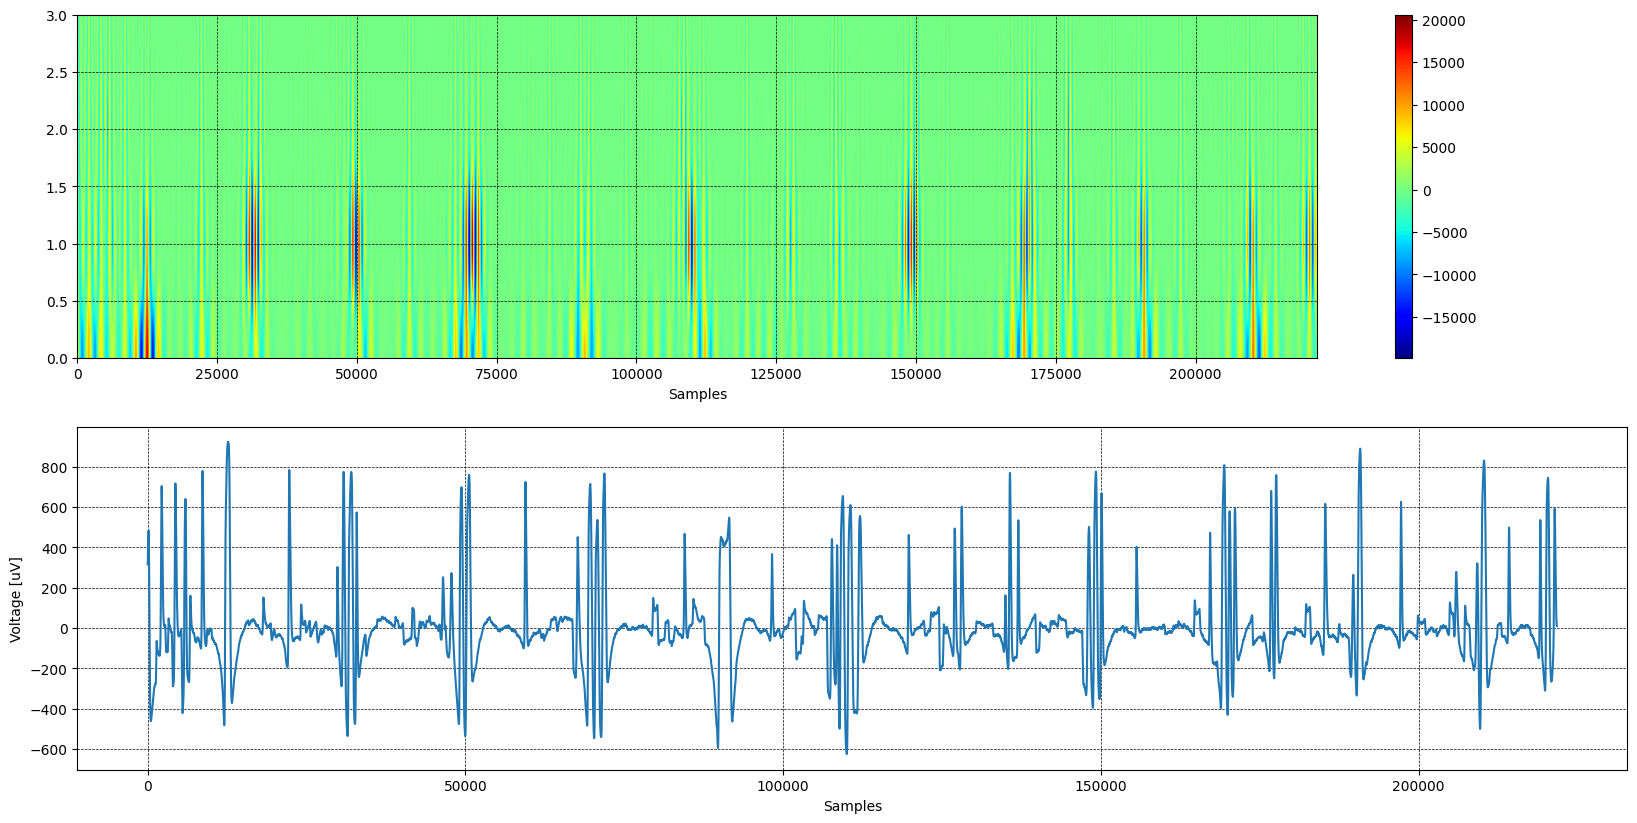

In [ ]:
#print(pywt.wavelist(kind = 'continuous'))
sf = []
for sig in [V]:
  wv = pywt.ContinuousWavelet('morl')
  f = pywt.scale2frequency(wv,  [1, 2, 3, 4,5,10,15,20])/dt
  coeffs, freqs = pywt.cwt(sig, f, 'morl')
  #for i in range(1,len(coeffs)):
    #coeffs[i] = np.zeros(len(coeffs[i]))
cmeans = np.mean(coeffs, axis = 0)
plt.subplot(2,1,1)
plt.imshow(coeffs,  cmap='jet', origin = 'lower', aspect='auto') #cmap='accent' jest BARDZO kontrastowy ale można zmienić 
plt.colorbar()
plt.xlabel('Samples')
plt.ylim(0,3)
plt.subplot(2,1,2)
plt.plot(V)
plt.xlabel('Samples')
plt.ylabel('Voltage [uV]')
'''
ll = 20*Fs #8, 35
hl = 80*Fs #26, 55

plt.figure(tight_layout = True)
plt.subplot(2,1,1)
plt.plot(t[ll:hl], sf[0][ll:hl],linewidth=3.5)
#plt.plot(t[ll:hl],H[ll:hl],linewidth=3.5)
plt.plot(t[ll:hl],MTags[ll:hl]*100, label = 'middle', linewidth=2)
plt.plot(t[ll:hl],LTags[ll:hl]*100, label = 'left', linewidth=2)
plt.plot(t[ll:hl],RTags[ll:hl]*100, label = 'right', linewidth=2)
plt.plot(t[ll:hl],UTags[ll:hl]*100, label = 'up', linewidth=2)
plt.plot(t[ll:hl],DTags[ll:hl]*100, label = 'down', linewidth=2)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.legend()
plt.subplot(2,1,2)
plt.plot(t[ll:hl], sf[1][ll:hl], linewidth=3.5)
plt.plot(t[ll:hl],V[ll:hl],linewidth=3.5)
plt.plot(t[ll:hl],MTags[ll:hl]*300, label = 'middle', linewidth=2)
plt.plot(t[ll:hl],LTags[ll:hl]*300, label = 'left', linewidth=2)
plt.plot(t[ll:hl],RTags[ll:hl]*300, label = 'right', linewidth=2)
plt.plot(t[ll:hl],UTags[ll:hl]*300, label = 'up', linewidth=2)
plt.plot(t[ll:hl],DTags[ll:hl]*300, label = 'down', linewidth=2)
plt.legend()
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]') 
'''

True


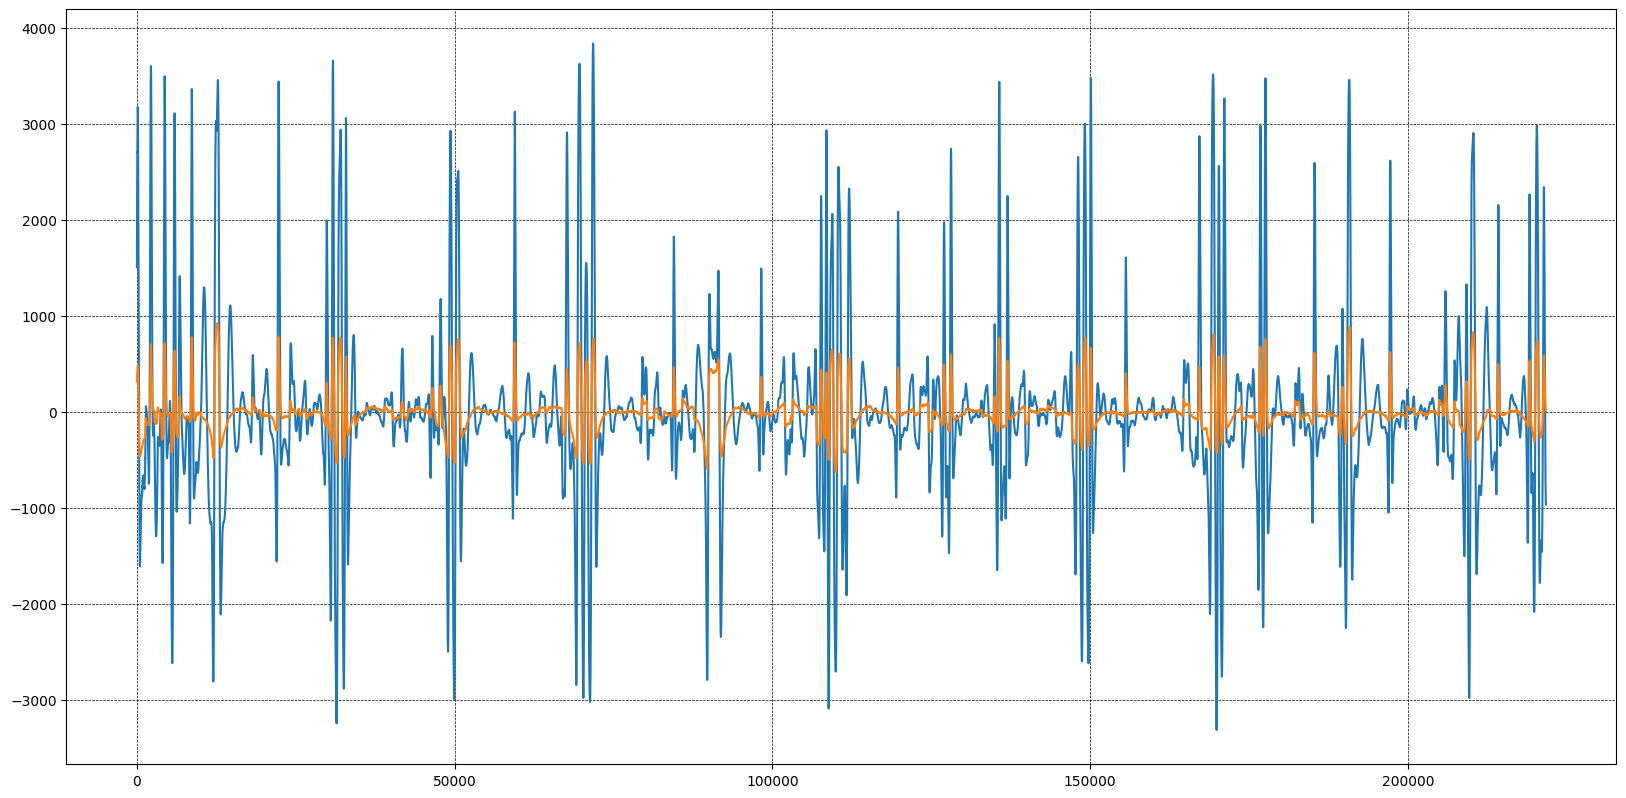

In [ ]:
plt.plot(np.mean(coeffs, axis = 0))
plt.plot(V)
print(len(coeffs[0]) == len(V))

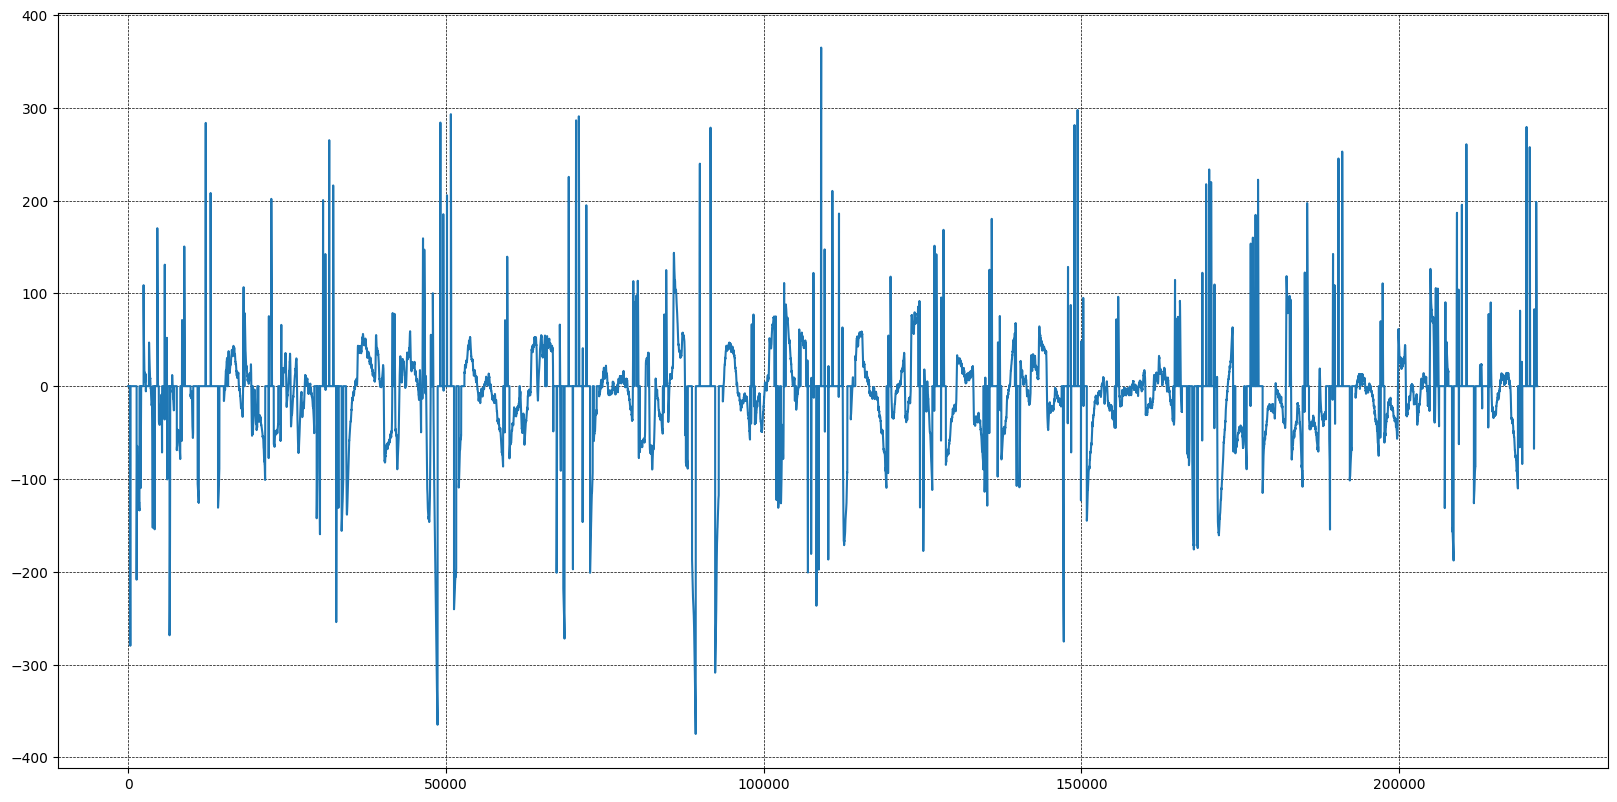

In [ ]:
bv = np.zeros(len(V))

mns = np.mean(coeffs, axis = 0)
for i in range(len(V)):
  if mns[i] >= 400 or mns[i] <= -400:
    bv[i] =  0
  else:
    bv[i] = V[i]

#plt.plot(bv)
#plt.plot(V)

Metoda splatania 

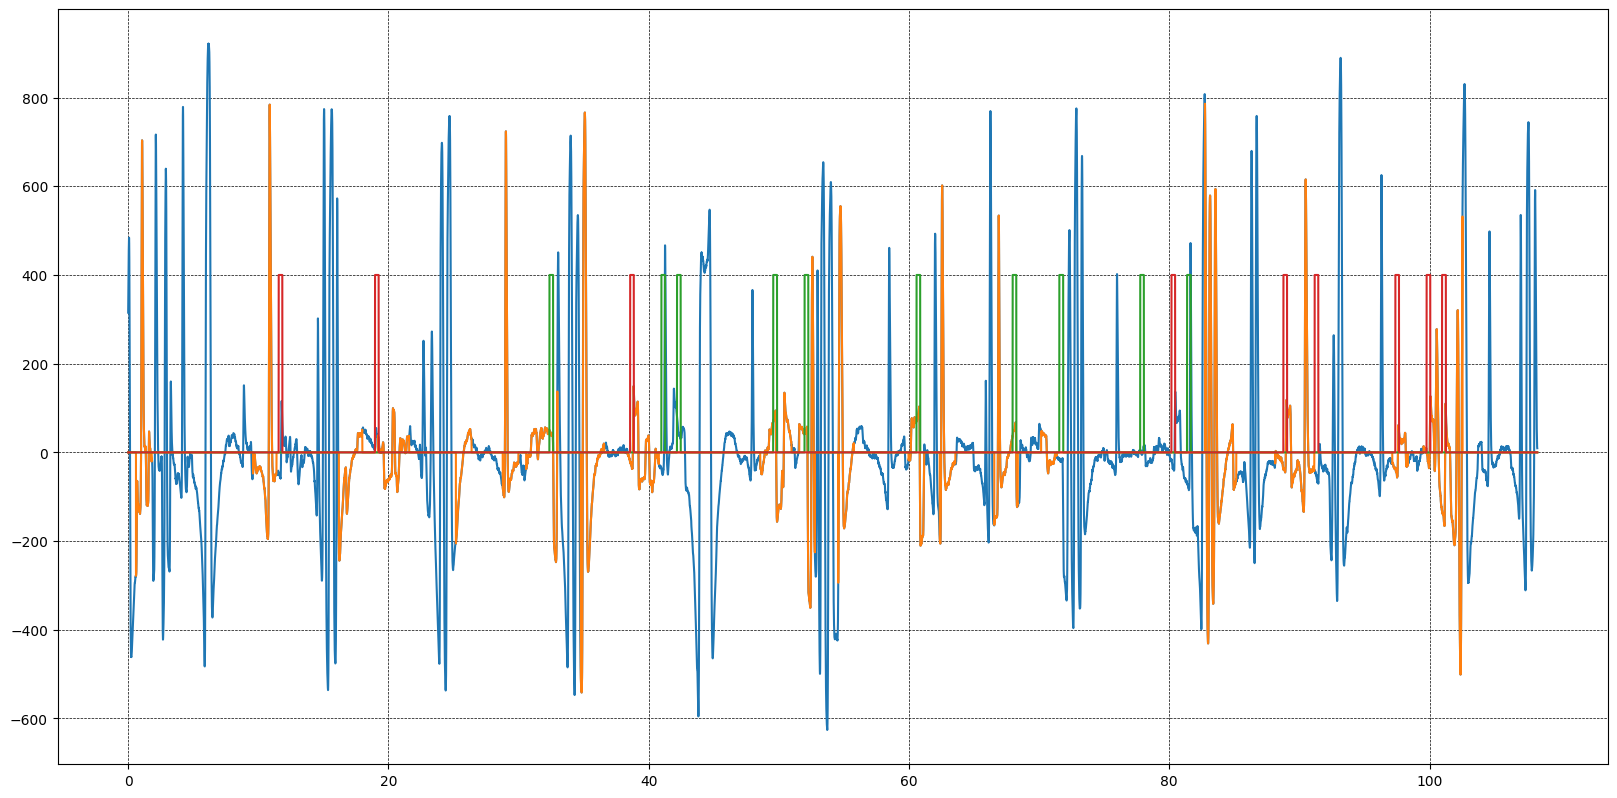

In [ ]:
#sakada hor + movements['00'][4]
#sakada hor - movements['01'][2]
#sakada ver + movements['12'][4]
#sakada ver - movements['13'][5]
#blink movements['10'][1]

wzory = [movements['00'][4]/np.linalg.norm(movements['00'][4][np.int(0.4*Fs):Fs]), 
         movements['01'][2]/np.linalg.norm(movements['01'][2][np.int(0.4*Fs):Fs]), 
         movements['12'][4]/np.linalg.norm(movements['12'][4][np.int(0.4*Fs):Fs]), 
         movements['13'][5]/np.linalg.norm(movements['13'][5][np.int(0.4*Fs):Fs]), 
         movements['10'][1]/np.linalg.norm(movements['10'][1][np.int(0.4*Fs):Fs])]

nH = H/np.linalg.norm(H)
nV = V/np.linalg.norm(V)

detect_Hp = []
detect_Hn = []
detect_Vp = []
detect_Vn = []
detect_Vb = []

start = 0
end = len(wzory[0]) #te same długości wzorów
step = len(wzory[0])
while end < len(t):
  detect_Hp.append((np.dot(nH[start:end], wzory[0]),start, end))
  detect_Hn.append((np.dot(nH[start:end], wzory[1]),start, end))
  detect_Vb.append((np.dot(nV[start:end], wzory[4]),start, end))
  start += step//2
  end = start + step

detected = [detect_Hp, detect_Hn, detect_Vp, detect_Vn]

detectedH = np.zeros(len(H))
detectedV = np.zeros(len(V))
blinklessV = np.zeros(len(V))

for item in detect_Vb:
  if item[0] >= 0.05 or item[0] <= -0.05:
    blink_removal = 0#np.mean(np.mean(V[item[2]:item[2]+1024])+np.mean(V[item[1]-1024:item[1]]))
    blinklessV[item[1]:item[2]] = blink_removal 
  else:
    blinklessV[item[1]:item[2]] = V[item[1]:item[2]]
blinklessV = blinklessV/np.linalg.norm(blinklessV)

start = 0
end = len(wzory[0]) #te same długości wzorów
step = len(wzory[0])

bbV = bv / np.linalg.norm(bv)
while end < len(t):
  detect_Vp.append((np.dot(bbV[start:end], wzory[2]),start, end))
  detect_Vn.append((np.dot(bbV[start:end], wzory[3]),start, end))
  start += step//2
  end = start + step

for s in [detect_Hp, detect_Hn]:
  for item in s:
    if item[0] >= 0.05 or item[0] <= -0.05:
      detectedH[item[1]:item[2]] = H[item[1]:item[2]]

for s in [detect_Vp, detect_Vn]:
  for item in s:
    if item[0] >= 0.04 and item[0] <= 0.07 or item[0] <= -0.04 and item[0] >= -0.07:
      detectedV[item[1]:item[2]] = V[item[1]:item[2]]
#[20*Fs:45*Fs]
plt.plot(t, V)
plt.plot(t, detectedV)
plt.plot(t, DTags*400)
plt.plot(t, UTags*400)

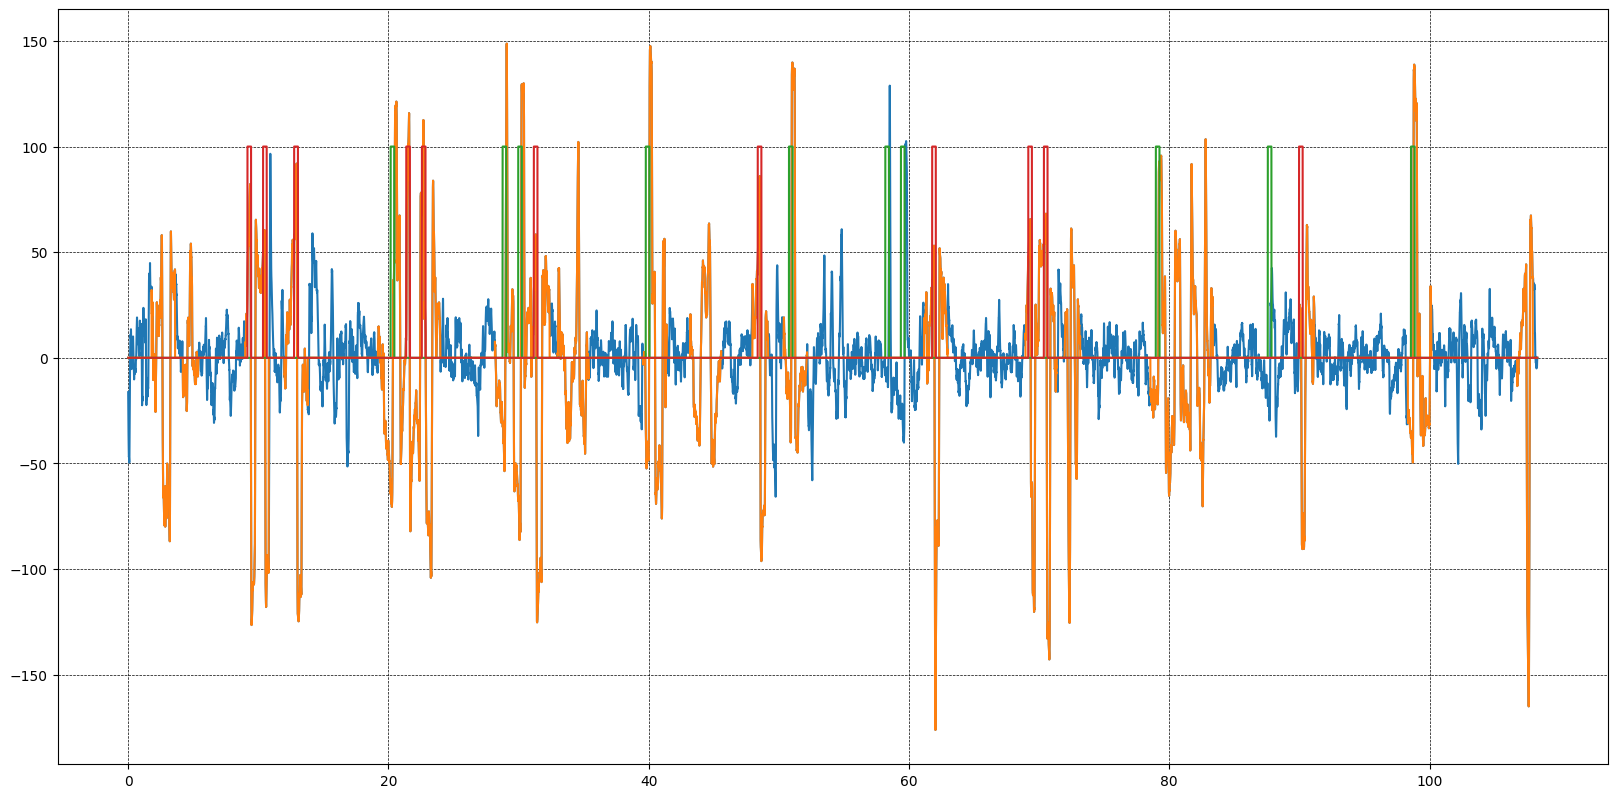

In [ ]:
plt.plot(t, H)
plt.plot(t, detectedH)
plt.plot(t, LTags*100)
plt.plot(t, RTags*100)

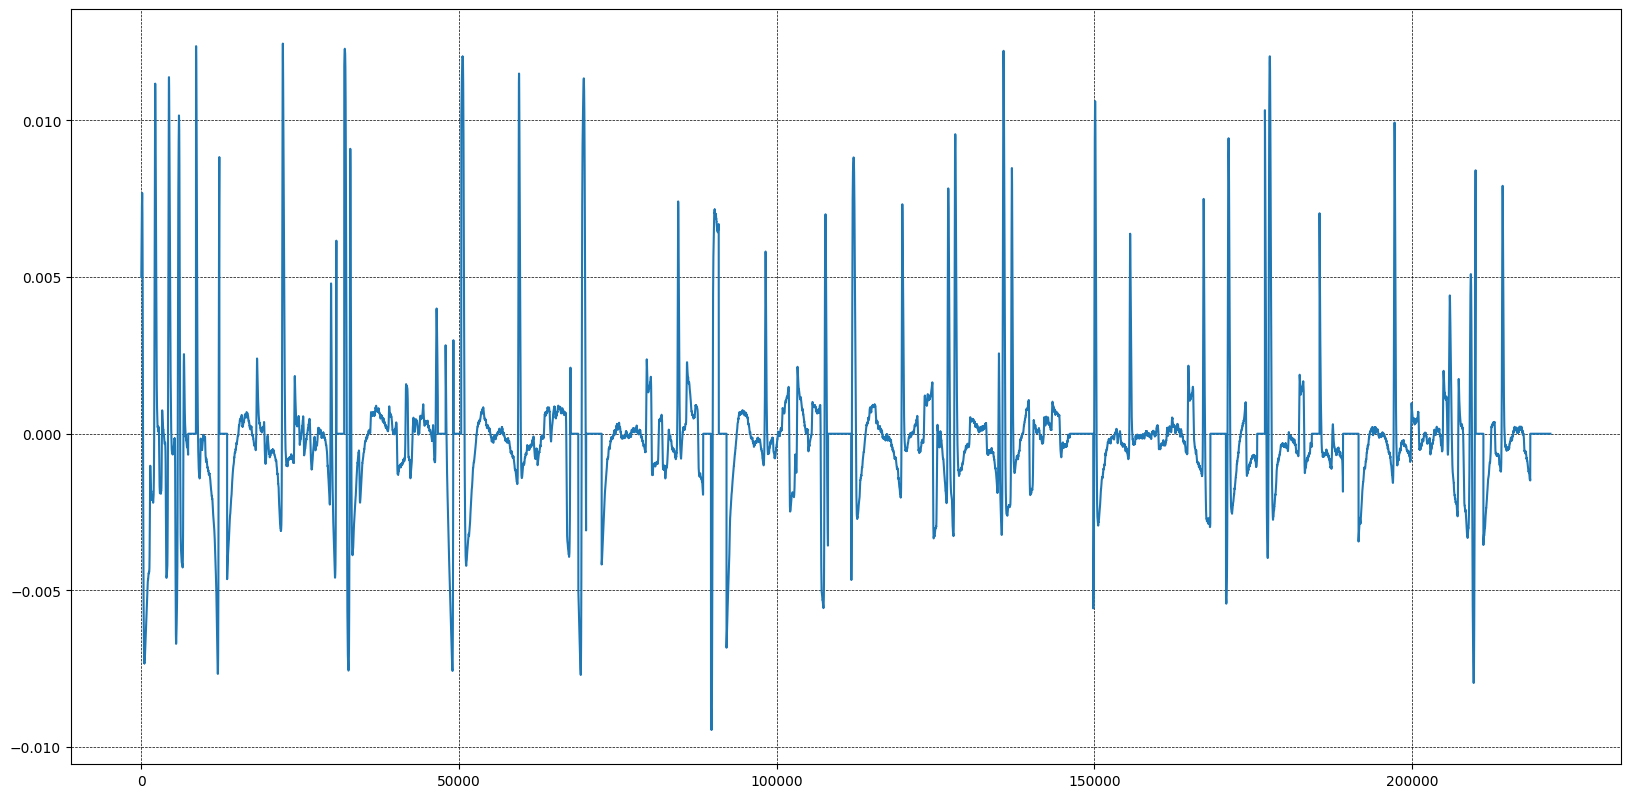

In [ ]:
plt.plot(blinklessV)

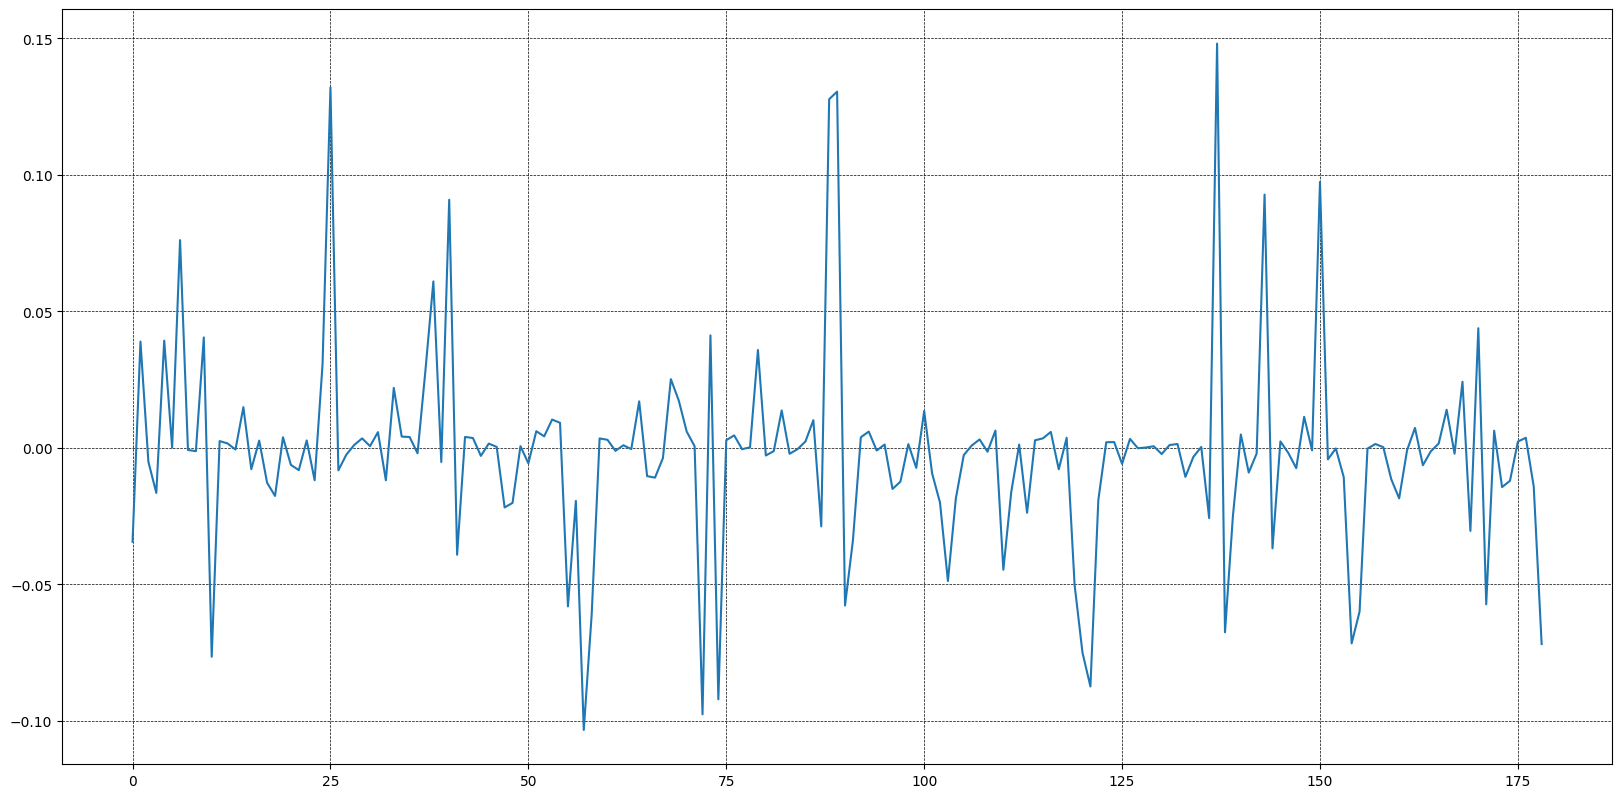

In [ ]:
plt.plot([detect_Vb[i][0] for i in range(len(detect_Vb))])


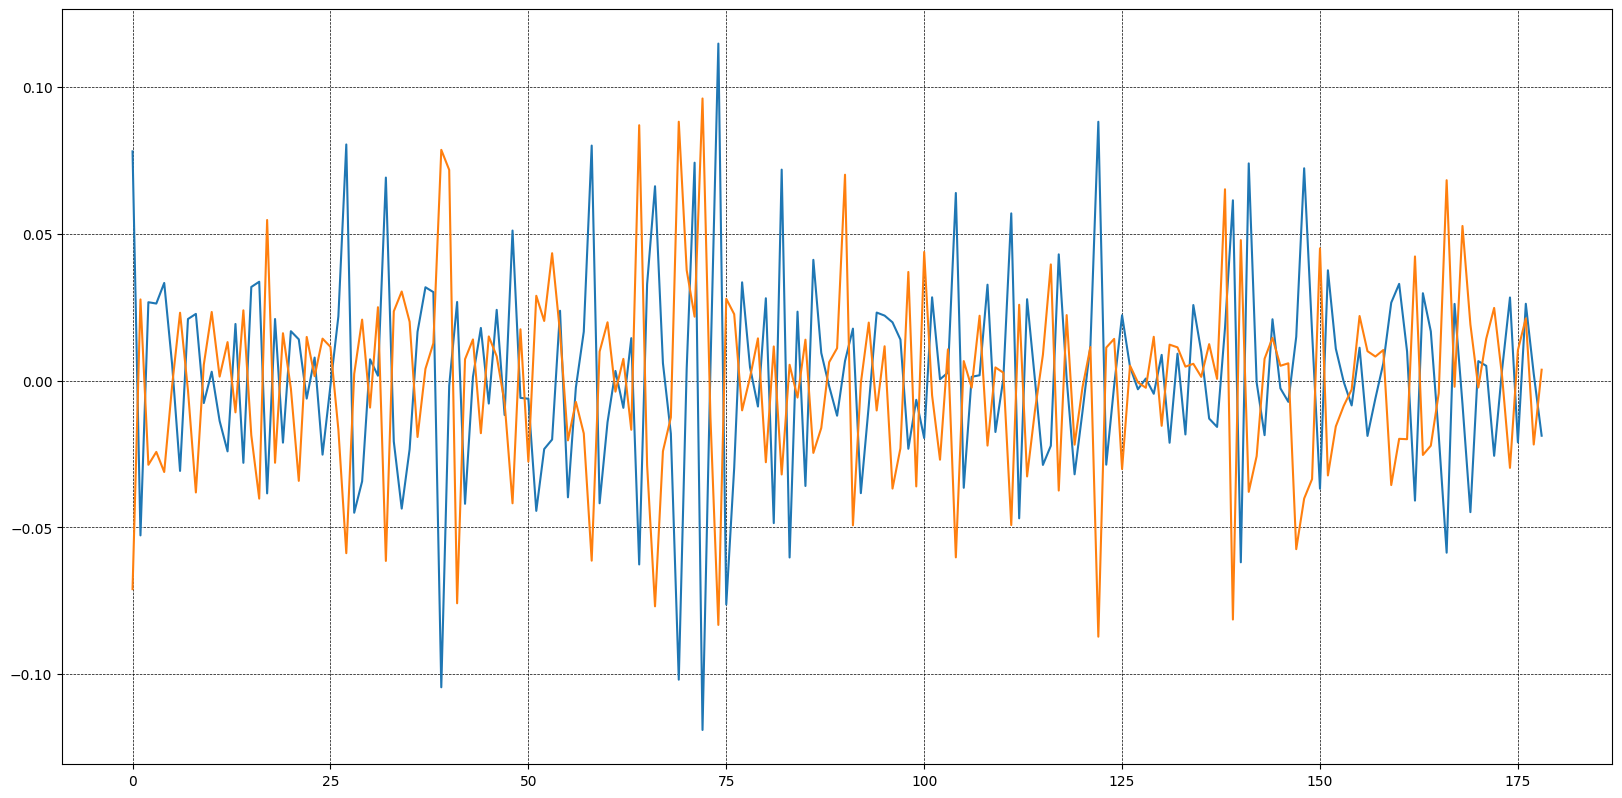

In [ ]:
plt.plot([detect_Vn[i][0] for i in range(len(detect_Vn))])
plt.plot([detect_Vp[i][0] for i in range(len(detect_Vp))])


Metoda KNN

In [ ]:
eog2 = ReadManager("eog_kwadraty_lukasz.xml", "eog_kwadraty_lukasz.raw", "eog_kwadraty_lukasz.tag")

channels_names_2 = eog2.get_param("channels_names")

print(channels_names_1)

# Pobierz cały, wybrany kanał
HOR2 = eog2.get_channel_samples("hor") * 0.0715
VER2 = eog2.get_channel_samples("ver") * 0.0715

#Parametry podstawowe
Fs = 2048
T2 = len(HOR2)/Fs 
dt = 1/Fs
t2 = np.arange(0,T2,dt)
f2 = np.arange(0.01,Fs/2,0.01)

# Pobierz wszystkie znaczniki
tags2 = eog2.get_tags()
tagnames2 = []
for tag in tags2:
  if tag['name'] not in tagnames2:
    tagnames2.append(tag['name'])
print(tagnames2)

2021-06-01 11:43:16,117 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['hor', 'ver', 'TSS']
['middle', 'lewo', 'dol', 'prawo', 'gora']


In [ ]:
sf2 = []
for sig in [HOR2, VER2]:
  coeffs = pywt.wavedec(sig, 'rbio6.8', level=12)
  for i in range(1,len(coeffs)): #powinno być 1 w range pierwsze
    coeffs[i] = np.zeros(len(coeffs[i]))
  s = pywt.waverec(coeffs, wavelet = 'rbio6.8')
  sf2.append(sig - s)

sigs2 = [sf2[0], sf2[1]]
H2, V2 = filtry(sigs2)


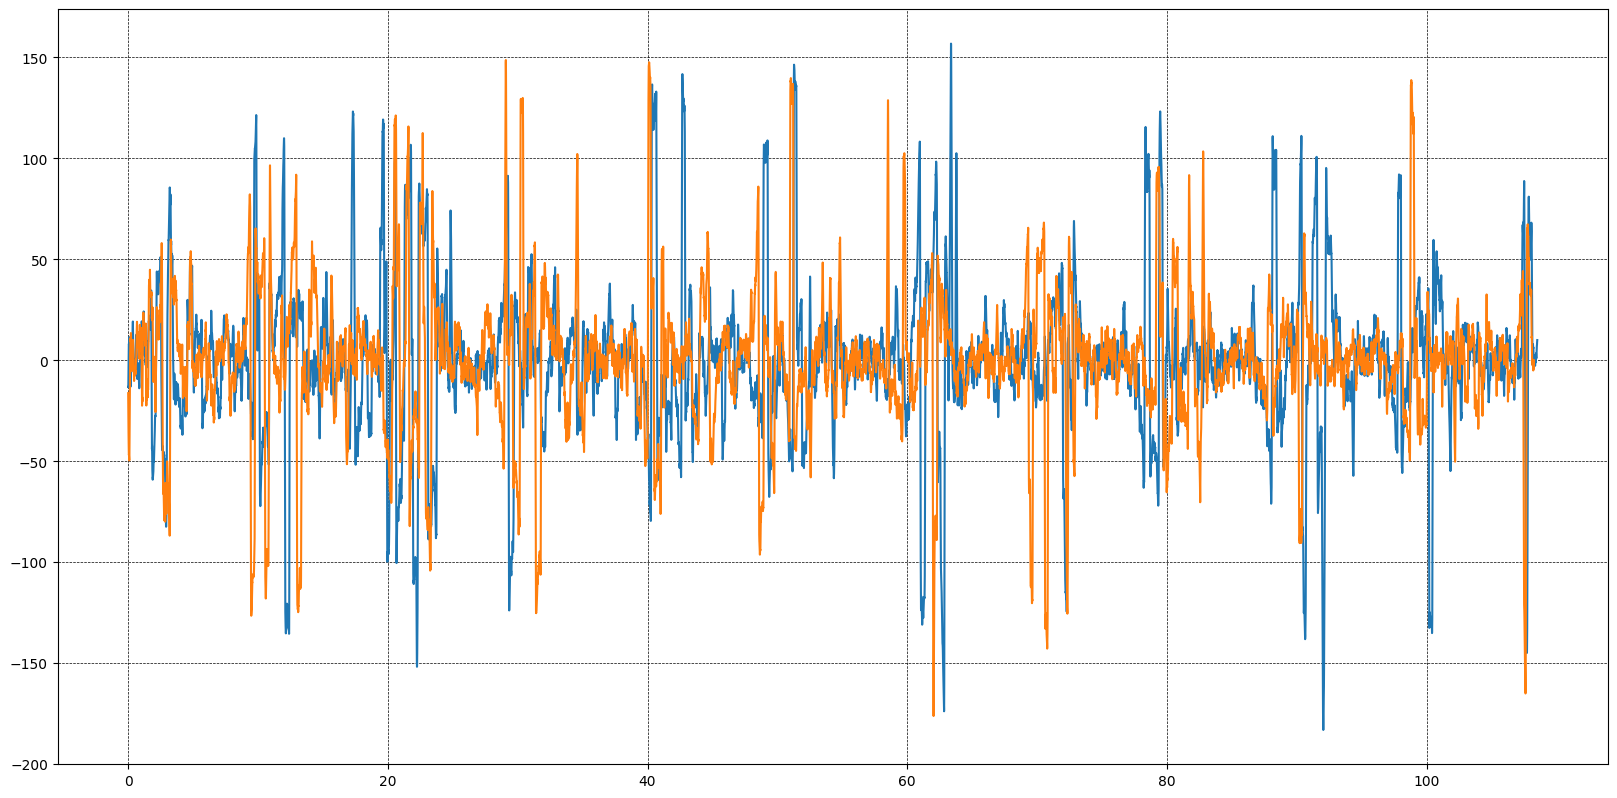

In [ ]:
plt.plot(t2,H2)
plt.plot(t, H)

In [ ]:
HPP2, HPPl2, HPP2i = FindSequence(H2, 200, 70, mode = 'ReturnPeakLengthsAndSigValues', dir = 'greater') #axis, PEAKS, positive/negative, opt. length, 2, opt indexes 
HPN2, HPNl2, HPN2i = FindSequence(H2, 200, -60, mode = 'ReturnPeakLengthsAndSigValues', dir = 'lower')

HPP2m = [np.mean(item) for item in HPP2]
HPN2m = [np.mean(item) for item in HPN2]

In [ ]:
VPP2, VPPl2, VPP2i = FindSequence(V2, 260, 30, mode = 'ReturnPeakLengthsAndSigValues', dir = 'greater')
VPN2, VPNl2, VPN2i = FindSequence(V2, 200, -100, mode = 'ReturnPeakLengthsAndSigValues', dir = 'lower')

VPP2m = [np.mean(item) for item in VPP2]
VPN2m = [np.mean(item) for item in VPN2]

In [ ]:
#interaktywny bs






Accuracy for dummy dataset: 1.0


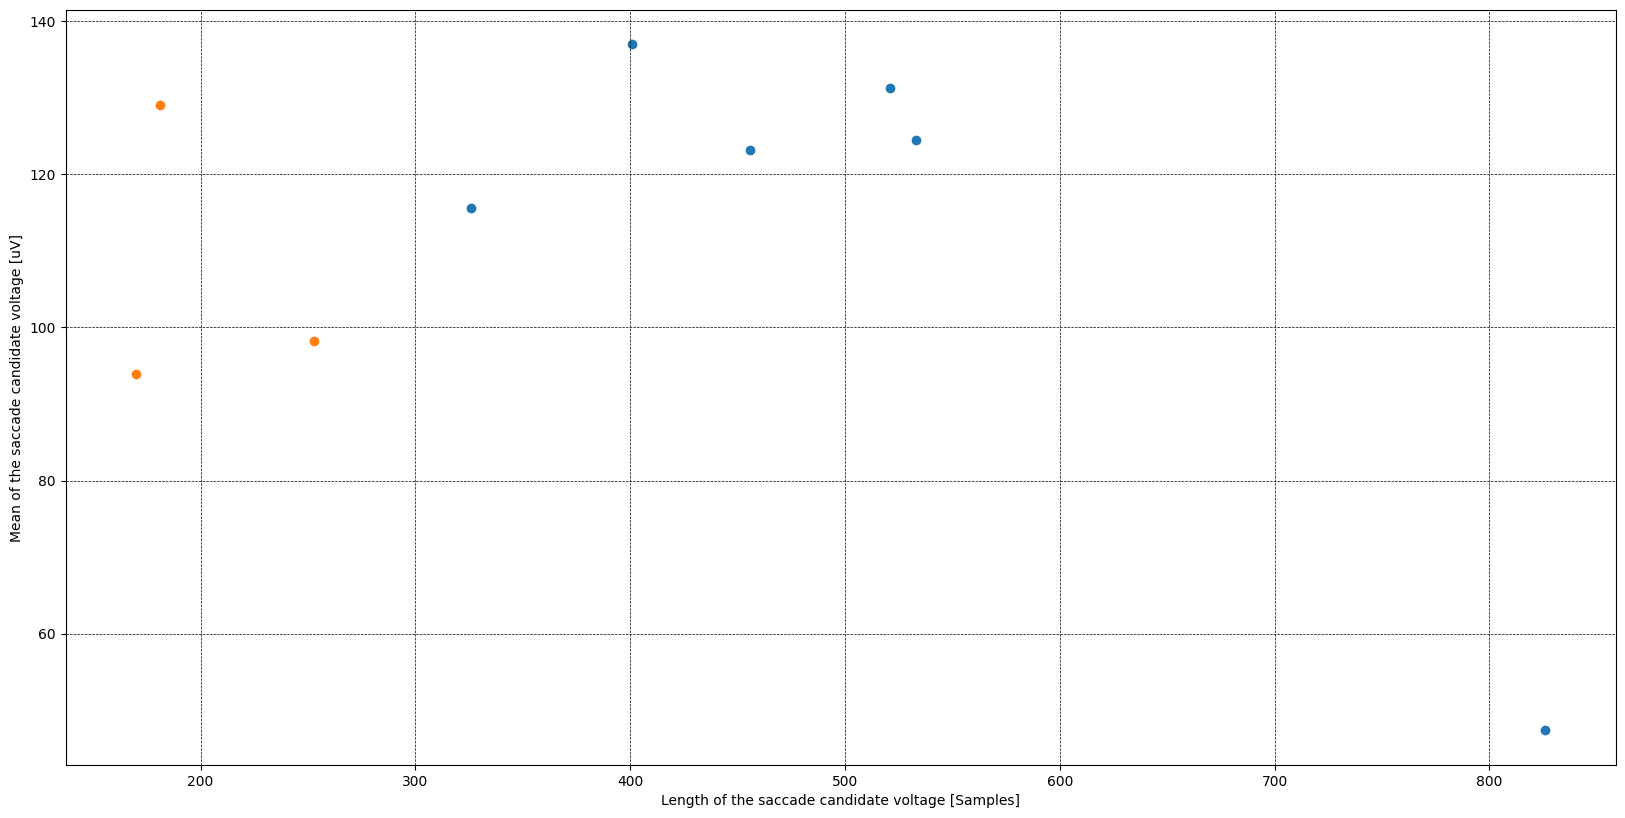

In [ ]:
#@title Choose datasets
Training_Dataset = hor_pos_train #@param ["hor_pos_train", "hor_neg_train", "ver_pos_train", "ver_neg_train"] {type:"raw"}
Predict_Dataset_Means = HPP2m #@param ["HPP2m", "HPN2m", "VPP2m", "VPN2m"] {type:"raw"}
Predict_Dataset_Lengths = HPPl2 #@param ["HPPl2", "HPNl2", "VPPl2", "VPNl2"] {type:"raw"}
Predict_Dataset_Indexes = HPP2i #@param ["HPP2i", "HPN2i", "VPP2i", "VPN2i"] {type:"raw"}
FSignal = H2 #@param ["H2", "V2"] {type:"raw"}


#Horizontal - Positive - zrob interaktywne?
dataset = pd.DataFrame({
  'Means': np.array(Predict_Dataset_Means),
  'Lengths': np.array(Predict_Dataset_Lengths),
})

trainDataset = pd.DataFrame({
  'Means': np.array(Training_Dataset[0]),
  'Lengths': np.array(Training_Dataset[1]),
  'Saccades': np.array(Training_Dataset[2])
})


'''
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(trainDataset['Saccades'],trainDataset['Means'],trainDataset['Lengths'])
'''
plt.scatter([Training_Dataset[1][i] for i in range(len(Training_Dataset[0])) if Training_Dataset[2][i] == 1],[Training_Dataset[0][i] for i in range(len(Training_Dataset[0])) if Training_Dataset[2][i] == 1])
plt.scatter([Training_Dataset[1][i] for i in range(len(Training_Dataset[0])) if Training_Dataset[2][i] == 0],[Training_Dataset[0][i] for i in range(len(Training_Dataset[0])) if Training_Dataset[2][i] == 0])
plt.ylabel('Mean of the saccade candidate voltage [uV]')
plt.xlabel('Length of the saccade candidate voltage [Samples]')

n_neighbors = 3

X = dataset[['Means', 'Lengths']] 

X_train = trainDataset[['Means', 'Lengths']] 
y_train = trainDataset['Saccades']

X_test = dataset[['Means', 'Lengths']]

#Split dataset into training set and test set
Xtr, Xte, ytr, yte = train_test_split(X_train, y_train, test_size=0.3) #70% training and 30% test

#Create a Gaussian Classifier
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance', metric = 'euclidean')

clf.fit(Xtr, ytr)
ypr = clf.predict(Xte)
#Model Accuracy, how often is the classifier correct?
print("Accuracy for dummy dataset:",metrics.accuracy_score(yte, ypr))

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

detected_saccades = np.zeros(len(FSignal))
for i in range(len(y_pred)):
  if y_pred[i] == 1:
    detected_saccades[Predict_Dataset_Indexes[i][0]:Predict_Dataset_Indexes[i][len(Predict_Dataset_Indexes[i])-1]] = FSignal[Predict_Dataset_Indexes[i][0]:Predict_Dataset_Indexes[i][len(Predict_Dataset_Indexes[i])-1]] 



Text(0, 0.5, 'Voltage [uV]')

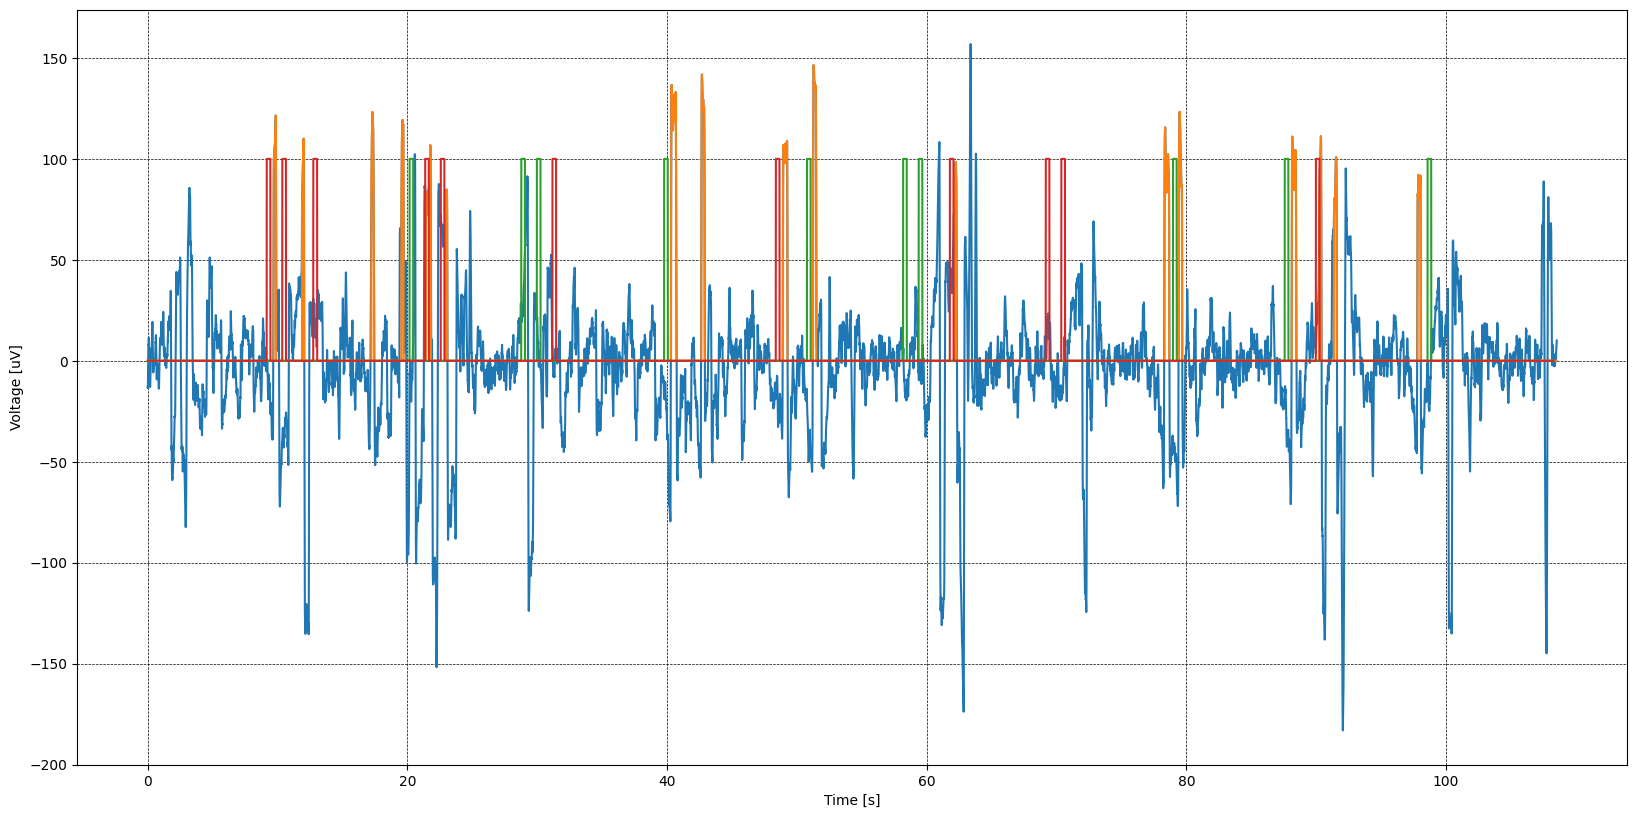

In [ ]:
plt.plot(t2, FSignal)
plt.plot(t2, detected_saccades)
plt.plot(t, LTags*100)
plt.plot(t, RTags*100)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
#[20*Fs:60*Fs]